# Diabetes Prediction (Binary Classification)

## Table of Contents

- [Introduction](#Introduction)
- [Data Overview  and Preparation](#Data-Overview-and-Preparation)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Model Training and Evaluation](#Model-Training-and-Evaluation)
- [Insights and Recommendations](#Insights-and-Recommendations)

## Introduction

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases, and for this specific project was pulled from [kaggle](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database/data). The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

## Dataset Overview
The dataset encompasses 8 predictor variables and the target variable `Outcome`:

* **Pregnancies**: Number of times pregnant
* **Glucose**: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* **BloodPressure**: Diastolic blood pressure (mm Hg)
* **SkinThickness**: Triceps skin fold thickness (mm)
* **Insulin**: 2-Hour serum insulin (mu U/ml)
* **BMI**: Body mass index (weight in kg/(height in m)^2)
* **DiabetesPedigreeFunction**: Diabetes pedigree function (a function that scores the probability of diabetes based on family history, with a realistic range of 0.08 to 2.42; [source]( https://dergipark.org.tr/en/download/article-file/1970853#:~:text=The%20'DiabetesPedigreeFunction'%20is%20a%20function,1%20represents%20those%20with%20diabetes)
* **Age**: Age (years)
* **Outcome**: Class variable (0 or 1) 268 of 768 are 1, the others are 0

## Objective
The primary objective is to leverage this data to build a predictive model that predicts whether a patient has diabetes. Insights derived from this analysis will help healthcare professionals identify high-risk individuals and implement early interventions to manage and prevent diabetes. Additionally, this model can contribute to understanding the significant predictors of diabetes, aiding in better resource allocation and targeted awareness campaigns.

By developing a robust predictive model, we aim to:

* Improve diagnostic accuracy for diabetes in clinical settings.
* Identify key risk factors that contribute to the development of diabetes.
* Support the development of personalized treatment plans and preventive measures.
* Enhance overall public health strategies for diabetes management and prevention.

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Set display options for IPython
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, f1_score, recall_score, precision_score
)
from sklearn.inspection import permutation_importance

# Set display options for pandas
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

# Set plot parameters
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 75

# Set seaborn style
sns.set(style="whitegrid")

In [2]:
df = pd.read_csv('../data/diabetes.csv')

## Data Overview and Preparation

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.60,0.63,50,1
1,1,85,66,29,0,26.60,0.35,31,0
2,8,183,64,0,0,23.30,0.67,32,1
3,1,89,66,23,94,28.10,0.17,21,0
4,0,137,40,35,168,43.10,2.29,33,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


* No missing values
* All features are numeric

In [5]:
df.duplicated().sum()

0

In [6]:
round(df.describe(), 2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,120.89,69.11,20.54,79.80,31.99,0.47,33.24,0.35
std,3.37,31.97,19.36,15.95,115.24,7.88,0.33,11.76,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.08,21.00,0.00
25%,1.00,99.00,62.00,0.00,0.00,27.30,0.24,24.00,0.00
50%,3.00,117.00,72.00,23.00,30.50,32.00,0.37,29.00,0.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00,1.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00,1.00


`Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, `BMI` all have zero values that need to be investigated

## Data Cleaning

#### Visualizing the Distribution of Zero Values

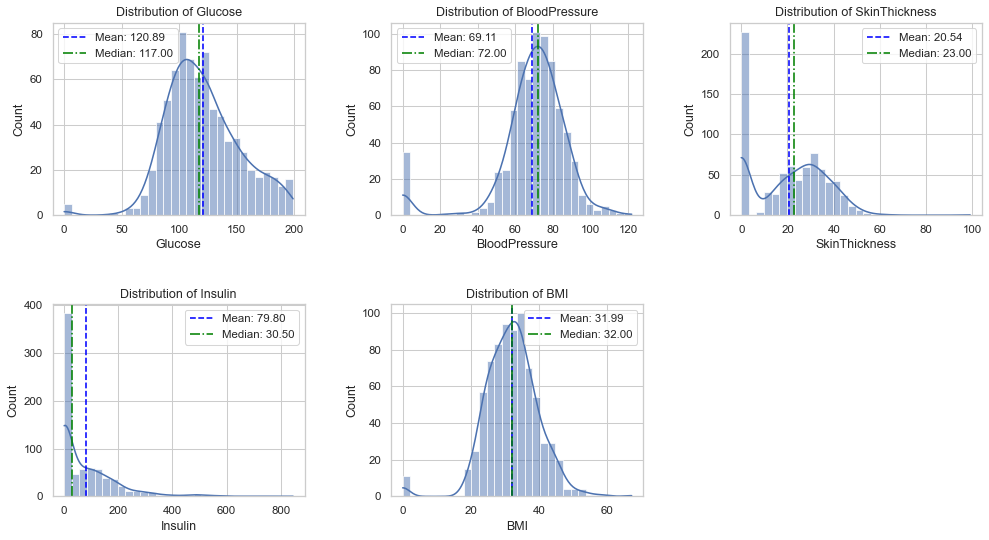

Number of zero values in each column:

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


In [7]:
# List of columns to check for zero values
columns_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Plotting the distribution of zero values for each column
plt.figure(figsize=(14, 8))
for i, column in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[column], bins=30, kde=True)
    plt.title(f'Distribution of {column}')
    
    # Calculate mean and median
    mean_value = df[column].mean()
    median_value = df[column].median()
    
    # Add vertical lines for mean and median
    plt.axvline(mean_value, color='blue', linestyle='--', label=f'Mean: {mean_value:.2f}')
    plt.axvline(median_value, color='green', linestyle='-.', label=f'Median: {median_value:.2f}')
    
    # Display the legend
    plt.legend()

plt.tight_layout(pad=3)
plt.show()

# Counting the number of zero values in each column
zero_counts = df[columns_to_check].apply(lambda x: (x == 0).sum())
print("Number of zero values in each column:\n")
print(zero_counts)

* `Glucose`, `BloodPressure`, `BMI` will be imputed with mean, as their distributions are Gaussian-like
* `SkinThickness`, `Insulin` will be imputed with median, as they both have outliers on the high end (right-skewed distributions with long tails)

In [8]:
# Columns to be imputed
impute_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Replace zero values with np.nan
df[impute_columns] = df[impute_columns].replace(0, np.nan)

# Impute with median values by the target variable (Outcome)
for column in impute_columns:
    df[column] = df.groupby('Outcome')[column].transform(lambda x: x.fillna(x.median()))

# Verify the imputation - check for zero values
columns_to_check = impute_columns
df[columns_to_check].apply(lambda x: (x == 0).sum())

Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64

In [9]:
# Checking new minimum values to see if they're realistic
df[columns_to_check].apply(lambda x: x.min()).astype('int')

Glucose          44
BloodPressure    24
SkinThickness     7
Insulin          14
BMI              18
dtype: int32

`Glucose` 44 mg/dL is quite low and would be considered hypoglycemic. Normal fasting blood glucose levels typically range from about 70 to 99 mg/dL. While 44 mg/dL is not impossible, it is uncommon and would indicate severe hypoglycemia.

`BloodPressure` 
* **24mm Hg** is extremely low and not physiologically realistic for a diastolic blood pressure. Normal diastolic blood pressure ranges from 60 to 80 mm Hg.
* **DBP < 40 mm Hg**: Critically low and **potentially dangerous**. This can lead to inadequate perfusion of vital organs.
* Physiological Limits: In a clinical setting, diastolic pressures **as low as 30 or 38 mm Hg are sometimes seen in critically ill patients**, particularly those in intensive care units (ICUs). These patients typically require immediate medical intervention, including fluids, medications to support blood pressure (vasopressors), and close monitoring.


In [10]:
# Looking at all features for patients with severely low blood pressure (something to investigate in future iterations)
df[df['BloodPressure'] < 40]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
18,1,103.00,30.00,38.00,83.00,43.30,0.18,33,0
125,1,88.00,30.00,42.00,99.00,55.00,0.50,26,1
597,1,89.00,24.00,19.00,25.00,27.80,0.56,21,0
599,1,109.00,38.00,18.00,120.00,23.10,0.41,26,0


## Exploratory Data Analysis

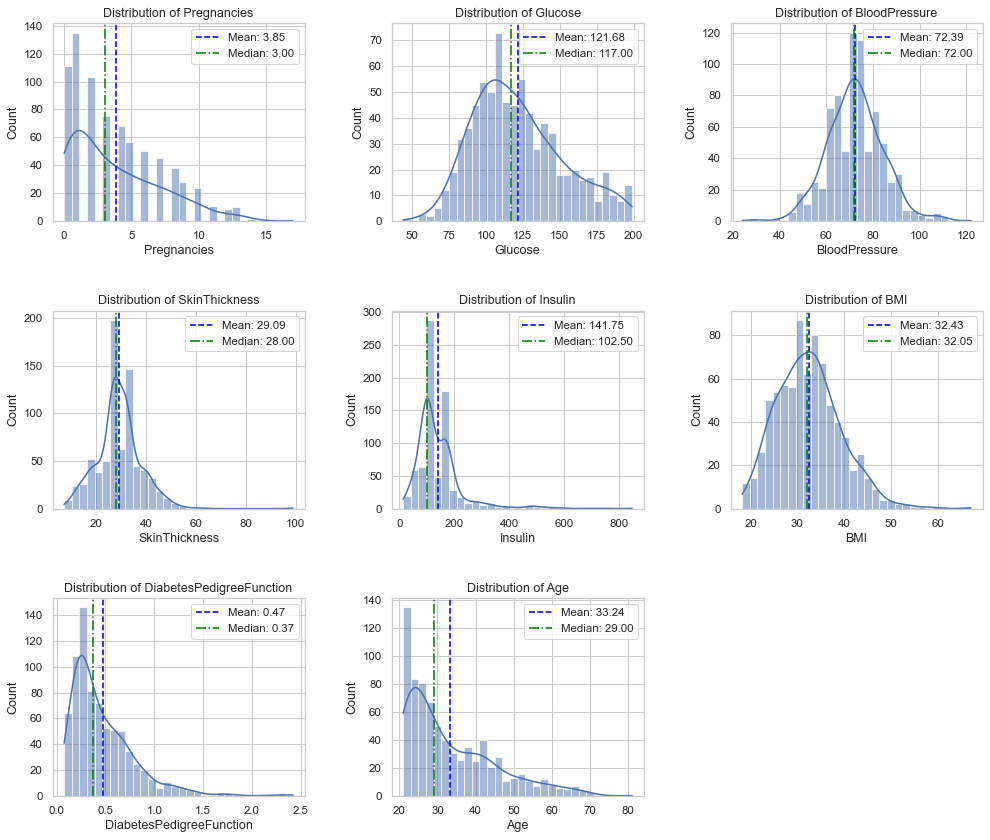

In [11]:
# All columns except 'Outcome'
features_both_classes = df.columns[:-1]

# Set up the figure for plotting
plt.figure(figsize=(14, 12))
num_cols = len(features_both_classes)
num_rows = (num_cols // 3) + 1

# Plot distributions for each column
for i, feature in enumerate(features_both_classes, 1):
    plt.subplot(num_rows, 3, i)
    sns.histplot(df[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
    
    # Calculate mean and median
    mean_value = df[feature].mean()
    median_value = df[feature].median()
    
    # Add vertical lines for mean and median
    plt.axvline(mean_value, color='blue', linestyle='--', label=f'Mean: {mean_value:.2f}')
    plt.axvline(median_value, color='green', linestyle='-.', label=f'Median: {median_value:.2f}')
    
    # Display the legend
    plt.legend()

plt.tight_layout(pad=3)
plt.show()

* The spikes for `SkinThickness` and `Insulin` have moved from zero to their median values

Additionally, non-imputed variables are right-skewed:
* Most number of `Pregnancies` are between 0 and 4
* `DiabetesPedigreeFunction` majority of values are clustered around 0.0 to 0.5
* `Age`: Half of the women are less than 30, while the remaining half are between about 30 and 80

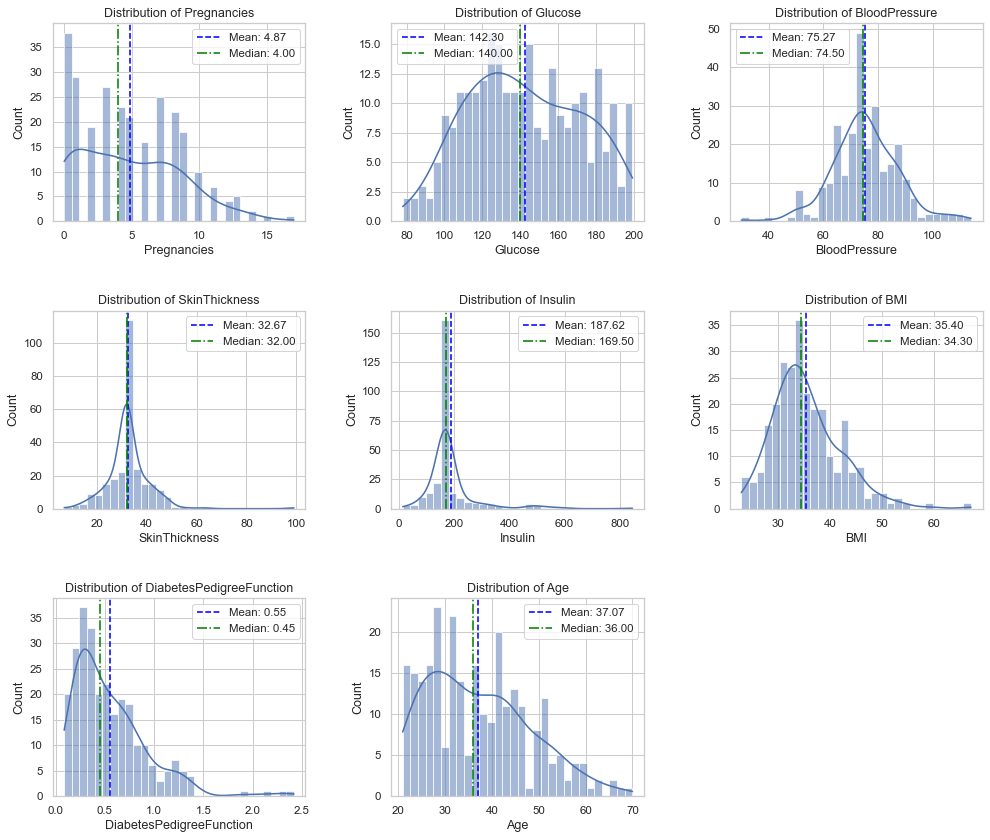

In [12]:
# Diabetic cases (Outcome = 1)
diabetic_cases = df[df['Outcome'] == 1]

# List of all columns except 'Outcome'
features_outcome_only = diabetic_cases.columns[:-1]

# Set up the figure for plotting
plt.figure(figsize=(14, 12))
num_cols = len(features_outcome_only)
num_rows = (num_cols // 3) + 1

# Plot distributions for each column
for i, column in enumerate(features_outcome_only, 1):
    plt.subplot(num_rows, 3, i)
    sns.histplot(diabetic_cases[column], bins=30, kde=True)
    plt.title(f'Distribution of {column}')
    
    # Calculate mean and median
    mean_value = diabetic_cases[column].mean()
    median_value = diabetic_cases[column].median()
    
    # Add vertical lines for mean and median
    plt.axvline(mean_value, color='blue', linestyle='--', label=f'Mean: {mean_value:.2f}')
    plt.axvline(median_value, color='green', linestyle='-.', label=f'Median: {median_value:.2f}')
    
    # Display the legend
    plt.legend()

plt.tight_layout(pad=3)
plt.show()

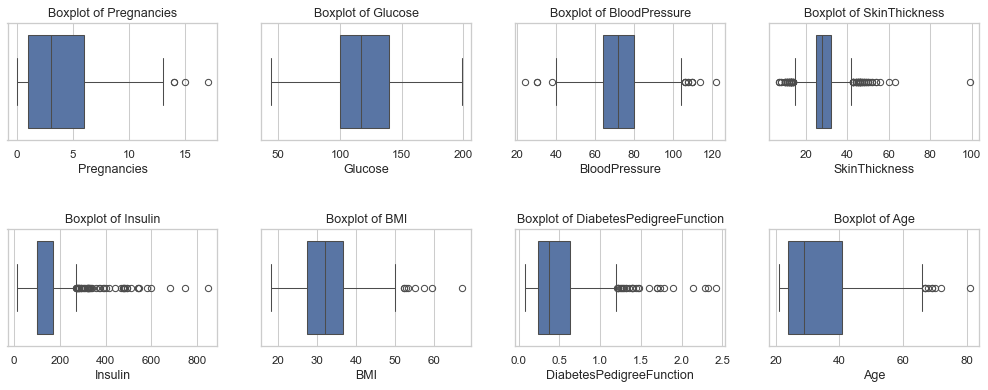

In [13]:
# All columns except 'Outcome'
plt.figure(figsize=(14, 6))

# Plot each feature
for i, feature in enumerate(features_both_classes, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x=feature, data=df, orient='h')
    plt.title(f'Boxplot of {feature}')

plt.tight_layout(pad=3)
plt.show()

Lots of outliers in Insulin and several in the last three variables, but nothing that needs to be treated

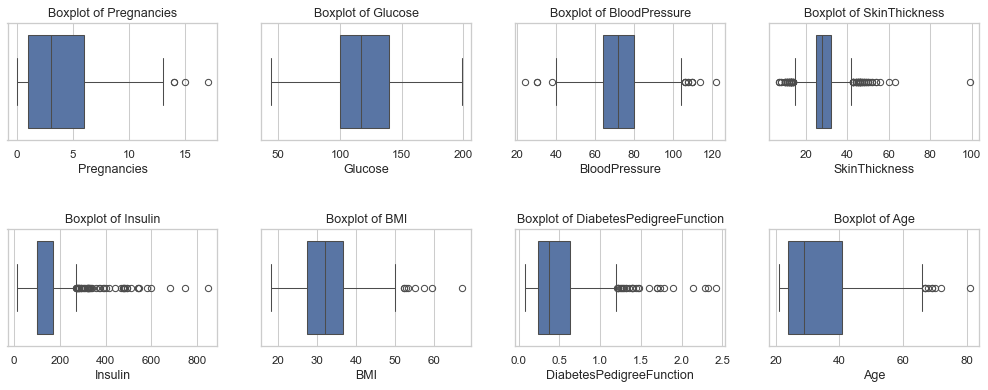

In [14]:
# Diabetic cases (Outcome = 1)
plt.figure(figsize=(14, 6))

# Plot each feature
for i, feature in enumerate(features_outcome_only, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x=feature, data=df, orient='h')
    plt.title(f'Boxplot of {feature}')

plt.tight_layout(pad=3)
plt.show()

### Multivariate Analysis

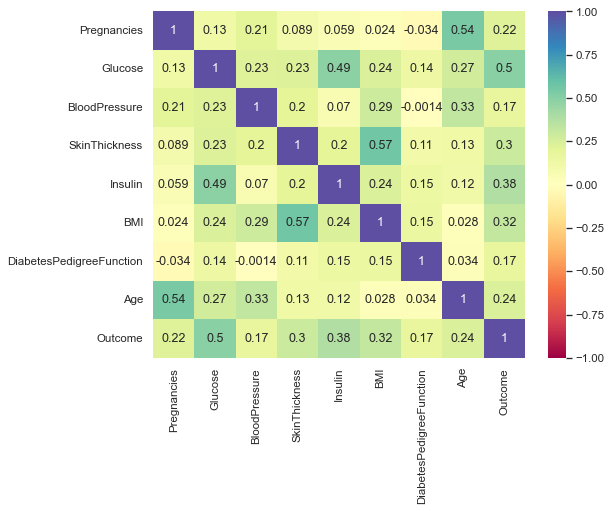

In [15]:
# Plotting a heatmap to quickly spot any high correlations
plt.figure(figsize=(8, 6))
sns.heatmap(data=df.corr(), annot=True, vmin=-1, vmax=1, cmap="Spectral")
plt.show()

No highly positive or highly negative correlations; only a few moderate correlations

In [16]:
# Summarizing any correlations over/under 0.5/-0.5
corr_matrix = df.corr()
threshold = 0.5
filtered_corr = corr_matrix[(corr_matrix > threshold) | (corr_matrix < -threshold)]
filtered_corr

# Remove self-correlations by setting diagonal to NaN
np.fill_diagonal(filtered_corr.values, np.nan)

# Drop rows and columns with all NaN values
filtered_corr = filtered_corr.dropna(how='all').dropna(axis=1, how='all')
filtered_corr

,Pregnancies,SkinThickness,BMI,Age
Pregnancies,NaN,NaN,NaN,0.54
SkinThickness,NaN,NaN,0.57,NaN
BMI,NaN,0.57,NaN,NaN
Age,0.54,NaN,NaN,NaN


**Moderate associations**
* `Age` vs `Pregnancies`: makes sense, as women who are older would tend to have had more pregnancies
* `BMI` vs `SkinThickness`: both BMI and SkinThickness estimate body fat percentage, so the data makes sense that both variables move in the same direction

#### Checking pairplot to see the the moderate relationships that do exist with more granularity

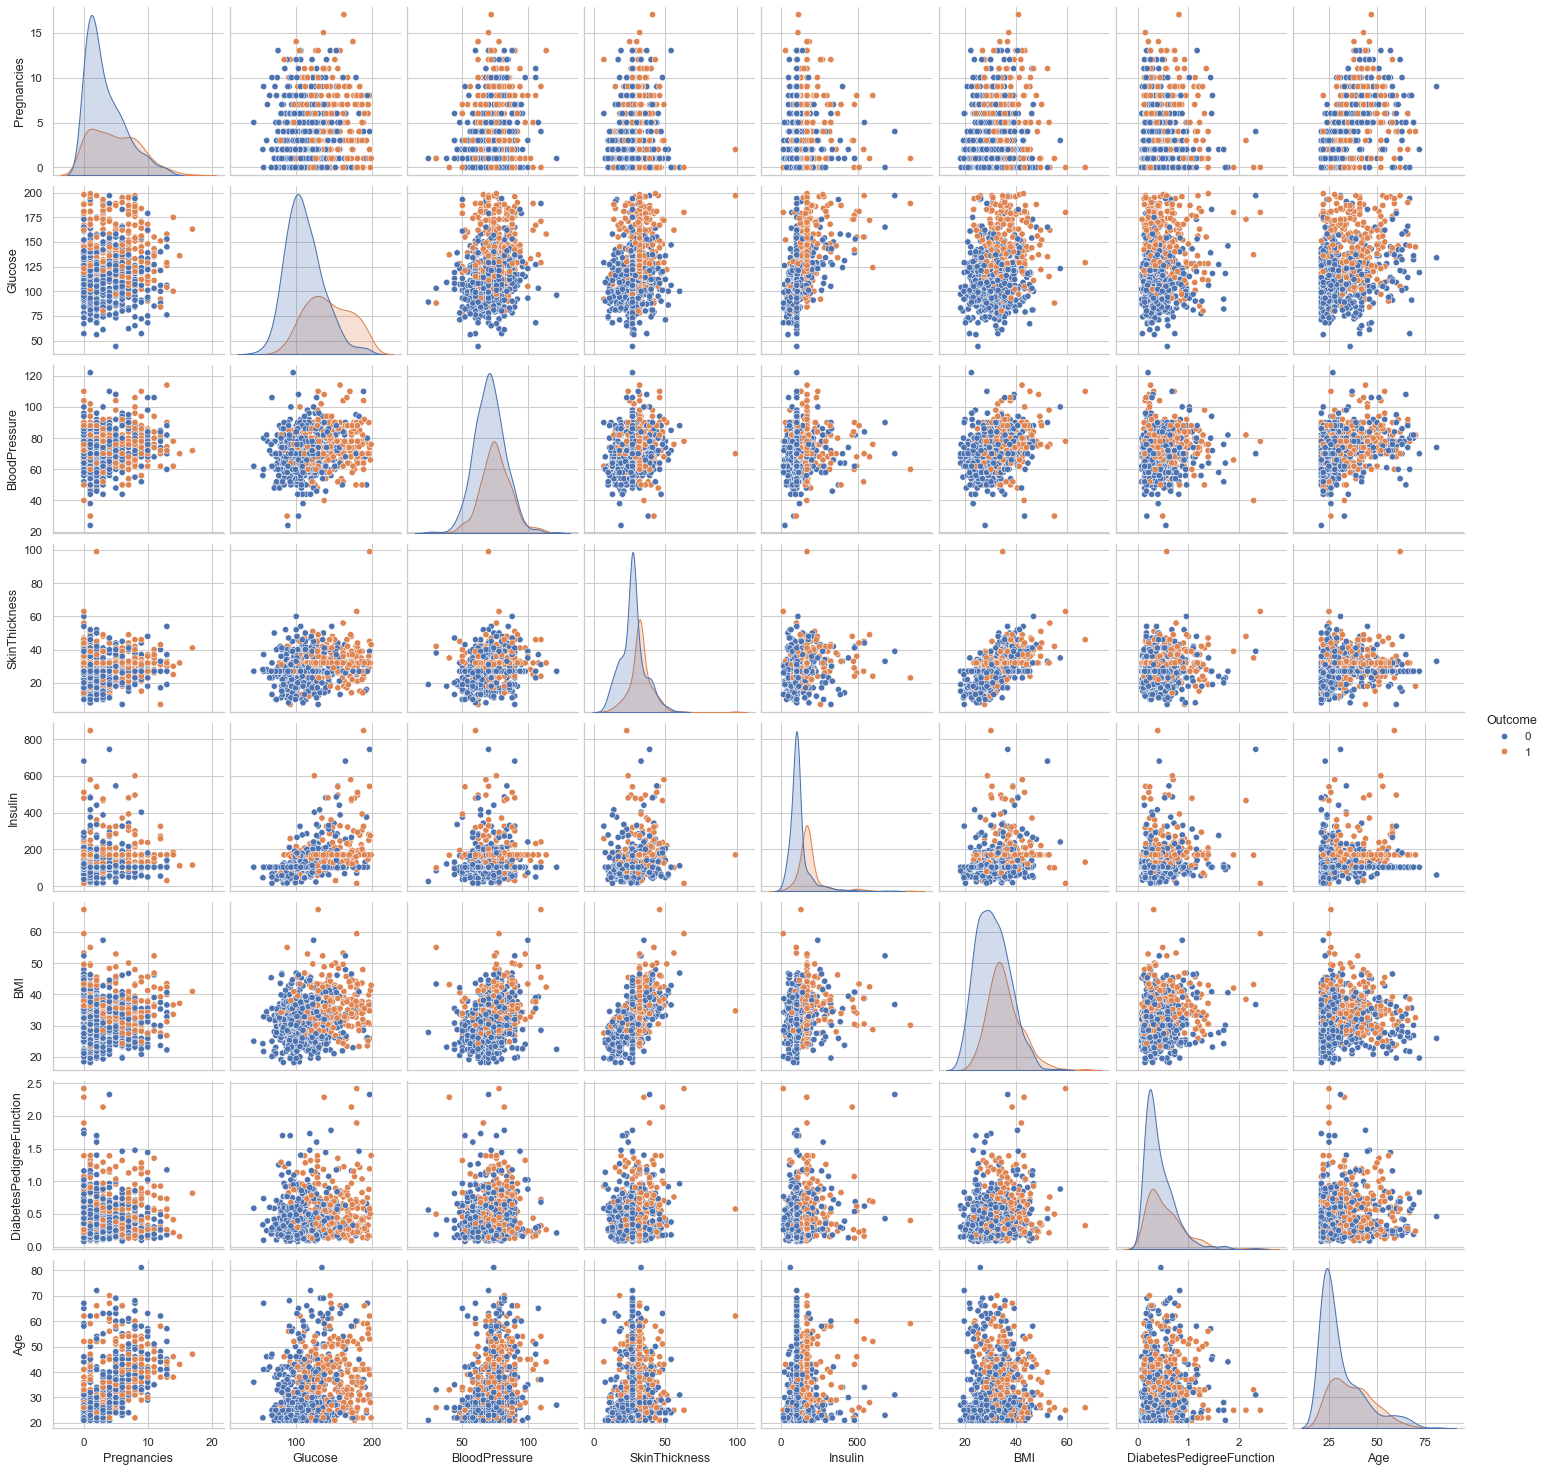

In [17]:
# Create a pairplot
sns.pairplot(df, hue='Outcome', diag_kind='kde')
plt.show()

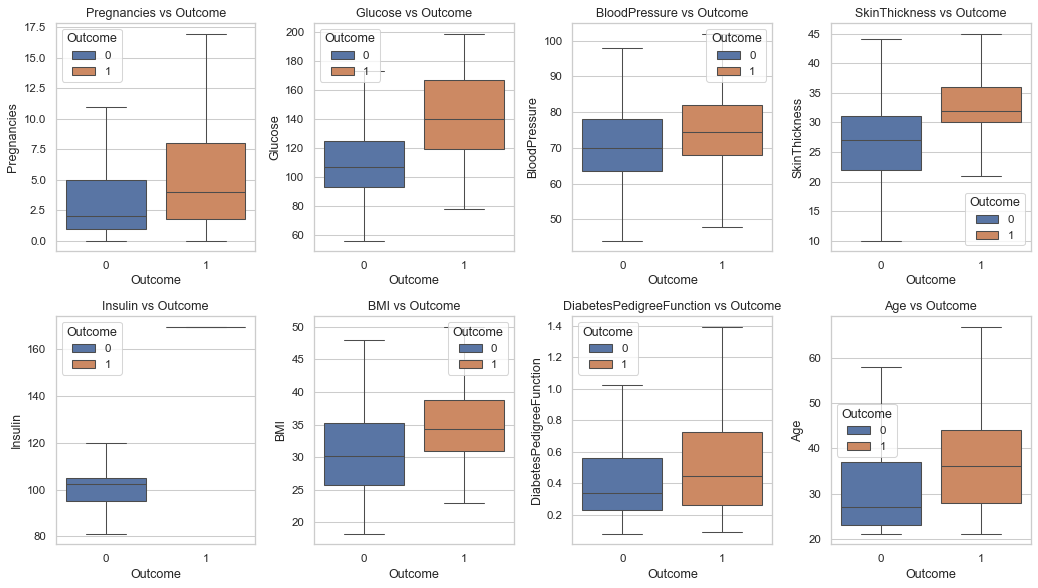

In [18]:
features = df.columns[:-1]

# Set up the matplotlib figure
plt.figure(figsize=(14, 8))

# Plot each feature against the target variable
for i, feature in enumerate(features, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x='Outcome', y=feature, data=df, hue='Outcome', showfliers=False)
    plt.title(f'{feature} vs Outcome')

plt.tight_layout()
plt.show()

All patients with diabetes (`Outcome` = 1) have higher values across every metric 

#### Outlier Detection

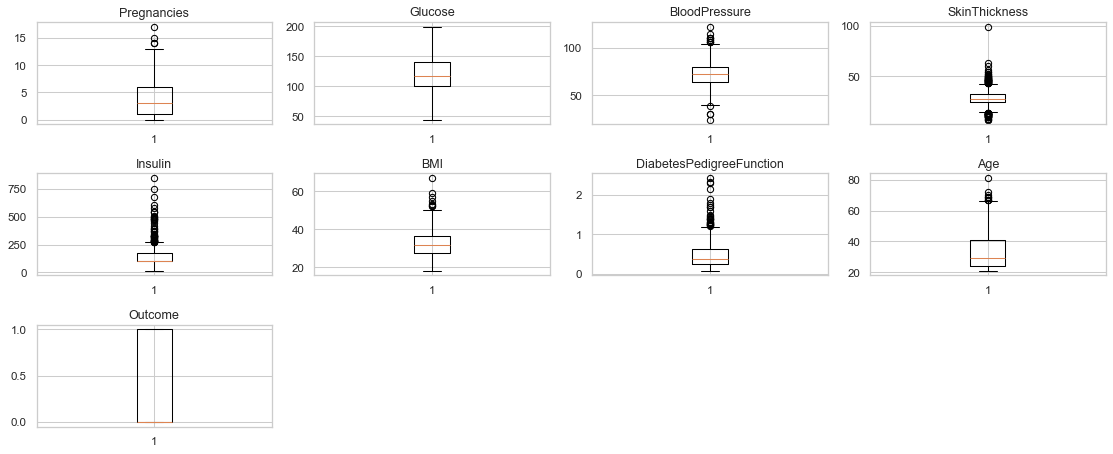

In [19]:
# outlier detection using boxplot
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(15, 12))

for i, variable in enumerate(numeric_columns):
    plt.subplot(6, 4, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

**Observations**

- There are quite a few outliers in the data.
- However, we will not treat them as they are proper values.

## Feature Engineering

In [20]:
# Define BMI categories
bmi_labels = ["Underweight", "Normal", "Overweight", "Obesity 1", "Obesity 2", "Obesity 3"]

# Assign BMI categories
df['NewBMI'] = pd.cut(df['BMI'], bins=[-float('inf'), 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')],
                      labels=bmi_labels)

# Check the distribution of the new BMI categories
print(df['NewBMI'].value_counts())

NewBMI
Obesity 1      235
Overweight     179
Obesity 2      150
Normal         102
Obesity 3       98
Underweight      4
Name: count, dtype: int64


In [21]:
# Define the condition for "Normal" insulin levels
df['InsulinCategory'] = pd.cut(df['Insulin'],
                               bins=[-float('inf'), 15, 166, float('inf')],
                               labels=['Abnormal', 'Normal', 'Abnormal'],
                               ordered=False)

# Check the distribution of the new insulin categories
df['InsulinCategory'].value_counts()

InsulinCategory
Normal      496
Abnormal    272
Name: count, dtype: int64

In [22]:
# Define the bins and labels for the glucose levels
bins = [-float('inf'), 70, 99, 126, float('inf')]
labels = ["Hypoglycemia", "Normal", "Borderline", "Hyperglycemia"]

# Use pd.cut to create the NewGlucose column
df['NewGlucose'] = pd.cut(df['Glucose'], bins=bins, labels=labels)

In [23]:
# One hot encoding
new_df = pd.get_dummies(df, columns = ["NewBMI", "InsulinCategory", "NewGlucose"], drop_first=True, dtype=int)

categorical_df = new_df.iloc[:, 10:]

## Data Preprocessing

In [24]:
new_df.Outcome.value_counts(1)

Outcome
0   0.65
1   0.35
Name: proportion, dtype: float64

In [25]:
y = new_df['Outcome']
X = new_df.drop(['Outcome', 'NewBMI_Normal',
       'NewBMI_Overweight', 'NewBMI_Obesity 1', 'NewBMI_Obesity 2',
       'NewBMI_Obesity 3', 'InsulinCategory_Normal', 'NewGlucose_Normal',
       'NewGlucose_Borderline', 'NewGlucose_Hyperglycemia'], axis=1)

In [26]:
cols = X.columns
index = X.index

In [27]:
# Concatenate numerical and categorical features
X = pd.concat([X, categorical_df], axis=1)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the feature sets
numeric_features = X_train.select_dtypes(include=['float64', 'int64', 'int32']).columns.tolist()

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features)
    ])

## Model Training and Evaluation

### Model evaluation criterion:

Model can make wrong predictions as:
1. Predicting a patient **will develop** diabetes and the patient does not - Loss of resources due to unnecessary treatment and patient anxiety.
    * This is a **false positive**.
    * The consequences include unnecessary medical tests, treatments, and patient stress or anxiety about a condition they do not have.
    * While it incurs costs and potential side effects, it ensures a conservative approach where more individuals are monitored.
<br>
<br>
2. Predicting a patient **will not develop** diabetes and the patient does - Loss of opportunity to identify patients at risk of developing diabetes and to intervene with preventative and early treatment efforts.
    * This is a **false negative**.
    * The consequences are more severe, including missed opportunities for early intervention, lifestyle changes, or treatments that could prevent or mitigate the severity of diabetes.
    * Patients may develop serious complications without timely medical attention.

**Which case is more important?**  
Scenario 2, reducing false negatives. Therefore, **Recall** should be maximized.  

Why Reducing False Negatives is Crucial:
* False negatives can lead to undiagnosed cases, delayed treatment, and higher long-term healthcare costs.
* Diabetes can lead to severe health issues such as cardiovascular diseases, nerve damage, kidney failure, and more. Early detection and management are critical to prevent these outcomes.

In [28]:
scorer = metrics.make_scorer(metrics.recall_score)

In [29]:
def model_performance_classification_sklearn(model, predictors, target, threshold=0.5):
    '''
    Function to compute different metrics to check classification model performance with a custom threshold

    model: classifier (supports predict_proba)
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    '''

    # Check if the model has predict_proba attribute
    if not hasattr(model, "predict_proba"):
        raise ValueError("Model does not support predict_proba")
        
    # Predicting probabilities
    y_prob = model.predict_proba(predictors)[:, 1]
    # Applying the threshold to get class predictions
    pred = (y_prob > threshold).astype(int)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # Creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            'Accuracy': [acc],
            'Recall': [recall],
            'Precision': [precision],
            'F1': [f1],
        }
    )

    return df_perf

## Building Initial Models

In [30]:
# Initialize models
models = [
    ('LR', LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear')),
    ('SVM', SVC(random_state=42, class_weight='balanced', probability=True)),
    ('RF', RandomForestClassifier(random_state=42, class_weight='balanced')),
    ('GB', GradientBoostingClassifier(random_state=42)),
    ('DT', DecisionTreeClassifier(random_state=42, class_weight='balanced')),
    ('ET', ExtraTreesClassifier(random_state=42, class_weight='balanced')),
    ('AB', AdaBoostClassifier(random_state=42)),
    ('XGB', XGBClassifier(random_state=42)),
]

# Define parameter grids
param_grids = {
    'LR': {'classifier__C': [0.01, 0.1, 1, 10, 100]},
    'SVM': {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf']},
    'RF': {'classifier__n_estimators': [50, 100, 200], 'classifier__max_depth': [None, 10, 20]},
    'GB': {'classifier__n_estimators': [50, 100, 200], 'classifier__learning_rate': [0.01, 0.1, 1]},
    'DT': {'classifier__max_depth': [None, 10, 20]},
    'ET': {'classifier__n_estimators': [50, 100, 200], 'classifier__max_depth': [None, 10, 20]},
    'AB': {'classifier__n_estimators': [50, 100, 200]},
    'XGB': {'classifier__n_estimators': [50, 100, 200], 'classifier__learning_rate': [0.01, 0.1, 1]},
}

# Evaluate using Stratified K-Folds and GridSearchCV
results = []
names = []
print('\nMean CV Recall on training dataset:\n')
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    
    param_grid = param_grids.get(name, {})
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=kfold, scoring=scorer, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    cv_result = cross_val_score(best_model, X_train, y_train, cv=kfold, scoring=scorer)
    results.append(cv_result)
    names.append(name)
    print(f'{name}: Mean CV Recall = {cv_result.mean():.3f} (± {cv_result.std() * 2:.3f})')


Mean CV Recall on training dataset:

LR: Mean CV Recall = 0.878 (± 0.120)
SVM: Mean CV Recall = 0.864 (± 0.153)
RF: Mean CV Recall = 0.840 (± 0.213)
GB: Mean CV Recall = 0.864 (± 0.172)
DT: Mean CV Recall = 0.788 (± 0.116)
ET: Mean CV Recall = 0.813 (± 0.157)
AB: Mean CV Recall = 0.817 (± 0.173)
XGB: Mean CV Recall = 0.873 (± 0.141)


Highest: Logistic Regression

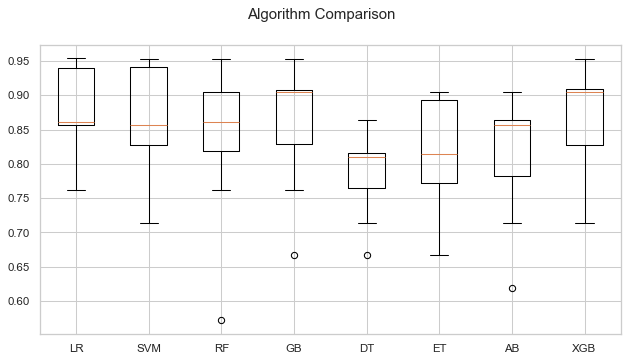

In [31]:
# Plot the results of each model's recall
fig = plt.figure(figsize=(10, 5))

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

## Hyperparameter Tuning

In [32]:
# Define the parameter grid for Logistic Regression
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__max_iter': [100, 200, 300]
}

# Create a pipeline with preprocessor and Logistic Regression
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))
])

# Set up the grid search
grid_search_lr = GridSearchCV(
    lr_pipeline,
    param_grid=param_grid_lr,
    scoring=scorer,
    cv=5,
    n_jobs=-1
)

# Fit the grid search to the data
grid_search_lr.fit(X_train, y_train)

# Print the best parameters and CV score
print('Best parameters are {} with CV score={}:'.format(grid_search_lr.best_params_, grid_search_lr.best_score_))

Best parameters are {'classifier__C': 0.01, 'classifier__max_iter': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'} with CV score=0.9294573643410852:


In [33]:
lr_tuned = grid_search_lr.best_estimator_
lr_tuned.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['Pregnancies', 'Glucose',
                                                   'BloodPressure',
                                                   'SkinThickness', 'Insulin',
                                                   'BMI',
                                                   'DiabetesPedigreeFunction',
                                                   'Age', 'NewBMI_Overweight',
                                                   'NewBMI_Obesity 1',
                                                   'NewBMI_Obesity 2',
                                                   'NewBMI_Obesity 3',
                                                   'InsulinCategory_Normal',
                                                   'NewGlucose_Normal',
                                                   'NewGlucose_Borderline',
                                                   'NewGlucose_Hyperglycemia'])])),
                ('classifier',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [34]:
# Calculate accuracy, recall, precision, and F1-score on the train set
lr_grid_train = model_performance_classification_sklearn(lr_tuned, X_train, y_train)
print('Training performance:')
lr_grid_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.73,0.94,0.57,0.71


In [35]:
# Perform cross-validation
cv_scores = cross_val_score(lr_tuned, X_train, y_train, cv=5, scoring=scorer)
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean CV Score: {cv_scores.mean()}')

Cross-validation scores: [0.85714286 0.95348837 0.93023256 0.93023256 0.97619048]
Mean CV Score: 0.9294573643410852


In [36]:
# Predict on test set
y_test_pred = lr_tuned.predict(X_test)
y_test_prob = lr_tuned.predict_proba(X_test)[:, 1]

# Calculate performance metrics
test_performance = model_performance_classification_sklearn(lr_tuned, X_test, y_test)
print("Test Performance:")
test_performance

Test Performance:


,Accuracy,Recall,Precision,F1
0,0.76,0.93,0.61,0.73


Tuned Logistic Regression model is generalizing well and not overfitting, as Recall is only one percentage point lower than training, and other metrics are within a few percentage points between training and test

In [37]:
# Print classification report
print("Test Classification Report:\n")
print(classification_report(y_test, y_test_pred))

Test Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.67      0.78        99
           1       0.61      0.93      0.73        55

    accuracy                           0.76       154
   macro avg       0.77      0.80      0.76       154
weighted avg       0.82      0.76      0.76       154



In [38]:
# Print confusion matrix
print("Test Confusion Matrix:\n")
print(confusion_matrix(y_test, y_test_pred))

Test Confusion Matrix:

[[66 33]
 [ 4 51]]


Although recall is high at 0.93, there are still 4 patients the model incorrectly classified as not having diabetes when they actually did (false negatives)

### Feature Importances

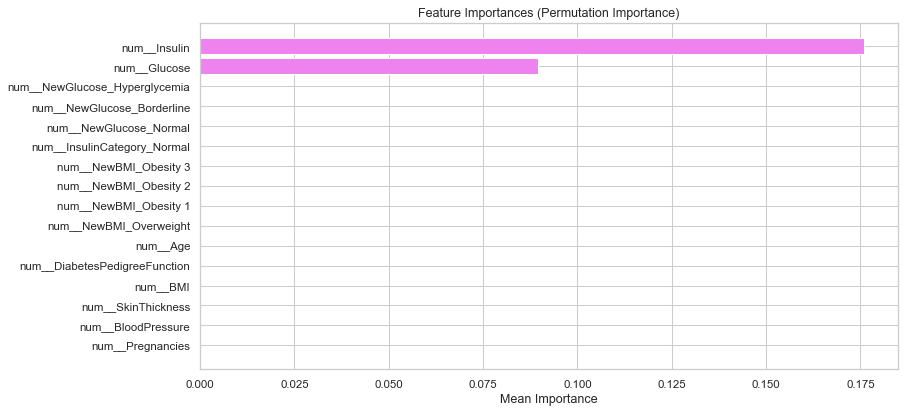

In [39]:
# Get feature names after preprocessing
feature_names = lr_tuned.named_steps['preprocessor'].get_feature_names_out()

# Perform permutation importance
result = permutation_importance(lr_tuned, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1)

# Extract importance and sort in descending order
sorted_indices = result.importances_mean.argsort()[::-1]
sorted_importances = result.importances_mean[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.title('Feature Importances (Permutation Importance)')
plt.barh(range(len(sorted_indices)), sorted_importances, color='violet', align='center')
plt.yticks(range(len(sorted_indices)), [sorted_feature_names[i] for i in range(len(sorted_indices))])
plt.xlabel('Mean Importance')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

Insulin and Glucose are the only significant features

## Insights and Recommendations

### Insights (in order of importance)

1. `Glucose`: The feature importance is nearly 3x the next highest importance. Blood glucose levels are a significant predictor of diabetes, which aligns with medical knowledge, as blood glucose levels are a key indicator of diabetes. 

`Age`, `DiabetesPedigreeFunction`, and `BMI` feature importances are close, in positions 2, 3, and 4.

2. `Age`: Age is also a crucial factor in predicting diabetes. Older individuals are generally at a higher risk of developing diabetes.
3. `DiabetesPedigreeFunction`: As this feature measures the genetic likelihood of diabetes based on family history, its importance indicates that genetics play a significant role in the risk of diabetes.
4. `BMI`: highlighting the role of obesity in diabetes risk. Higher BMI values are often associated with an increased risk of developing diabetes.

`Pregnancies`, `Insulin`, and `SkinThickness` feature importances are close positions 5, 6, and 7.

5. `Pregnancies`: The number of pregnancies also plays a role, suggesting that women who have been pregnant multiple times may have a higher risk of diabetes, possibly due to gestational diabetes.
6, 7. `Insulin and SkinThickness`: These features have moderate importance, indicating their relevance in predicting diabetes, possibly through their relationship with insulin resistance and body fat distribution.
8. `BloodPressure`: Despite being the least important feature in your model, it's still noteworthy, especially considering the observations about patients with extremely low blood pressure values. Low blood pressure might not be a strong indicator in this dataset, but it could still provide valuable insights when combined with other features or additional data.

### Recommendations:

1. Further Investigation on Glucose Levels:
Since `Glucose` is the most important feature, ensure that glucose measurements are accurate and consistent. Consider focusing on improving the precision of glucose level measurements and possibly collecting more granular data.

2. `Age`-Related Interventions:
Develop age-specific interventions and screening programs, especially targeting older populations, to catch early signs of diabetes.

3. Family History Analysis:
Encourage the collection of detailed family medical histories to better understand the genetic predisposition captured by the `DiabetesPedigreeFunction` feature.

4. `BMI` Management Programs:
Implement weight management programs and promote healthy lifestyles to reduce BMI and, consequently, the risk of diabetes.

5. `Pregnancy` and Gestational Diabetes:
Focus on monitoring women who have had multiple pregnancies or who had gestational diabetes, as they are at higher risk of developing diabetes later in life.

6. Augmenting `BloodPressure` Data:
Consider finding additional data or conducting studies to investigate patients with critically low blood pressure. This could involve looking into other health records or integrating external datasets that provide more context to blood pressure readings.

[Back to TOC](#Table-of-Contents)